# Graph embedding using SkipGram
The SkipGram model predicts wethever two values extracted from the available vocabulary are in the same context window or not.

In our implementatation, as for the CBOW model, since the batches walks are lazily generated, the memory requirements are minimal and the method can scale to very big graphs. It can also run on graphs like Monarch (150M edges and 50M nodes) provided that you use a GPU ([or better still a TPU](https://cloud.google.com/ai-platform/training/docs/using-tpus#console)) that is able to fit an embedding model that big, but that is just related to the shear number of nodes.

In [1]:
from embiggen import SkipGram, NodeSkipGramSequence
from ensmallen_graph import EnsmallenGraph

from tensorflow.keras.callbacks import EarlyStopping
import silence_tensorflow.auto
import numpy as np
from tensorflow.distribute import MirroredStrategy
from plot_keras_history import plot_history
from plot_keras_history.utils import chain_histories
import os
import pandas as pd

## Loading the graphs
We load the ppi graph as a weighted undirected graph.

In [10]:
graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi/edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    weights_column="weight"
)

As first thing, we plot a short report showing all the avalable graph details, including the number of edges, nodes, trap nodes and both the connected components and the strongly connected components.

In [3]:
graph.report()

{'edges_number': '588748',
 'density': '0.001993564869255138',
 'selfloops_percentage': '0',
 'bidirectional_percentage': '1',
 'traps_rate': '0',
 'connected_components_number': '181',
 'strongly_connected_components_number': '181',
 'unique_node_types_number': '0',
 'singleton_nodes': '0',
 'nodes_number': '17185',
 'degrees_median': '11',
 'degrees_mean': '34.25941227814955',
 'unique_edge_types_number': '0',
 'is_directed': 'false',
 'degrees_mode': '1'}

## Creating the holdouts
For every one of these examples, we are going to use two experimental setups.

We split the graph into a training and validation components.

Particularly, the training partition will have the same number of connected components as the original graph, while the validation may have more.

We split the two datasets at $0.8$, as done in [Yue et al.](https://academic.oup.com/bioinformatics/article/36/4/1241/5581350).

We are going to us two different experimental setups:

- One, based on the [Yue et al.](https://academic.oup.com/bioinformatics/article/36/4/1241/5581350) and [Leskovec et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5108654/) experimental setups, where we completely separate training negatives from validation negatives and leave the validation parts of the graphs (both positives and negatives) as "holes" in the graph, neither negative nor positive. This may be slighly sconnected from the real scenario, where we cannot remove from a graph part of the validation edges since they are not known. In particular, the negatives edges used in the validation have the same cardinality as the validation positive edges.
- The second one, as close as possible to a real scenario, we will share the negative edges in both the training and validation. In particular in this scenario the validation positive edges appear as negatives during the training, as the assumption made during training with the available data is that any edge that does not appear in the available data is negative.

**For the context of CBOW or GloVe, both setups are the one and the same. The difference is relevant in SkipGram embedding and LinkPrediction.**

### Splitting the graph into the two components

In [4]:
training, validation = graph.connected_holdout(42, 0.8)

The followings are check that are not necessary, but are offered as sanity checks:

In [ ]:
assert graph.contains(training + validation)
assert (training + validation).contains(graph)
assert not training.overlaps(validation)
assert not validation.overlaps(training)

### Preparing the two experimental setups
For both the experimental setups, we are using walk lengths of $100$ nodes, with batch size (number of walks to be considered in each batch) of $2^{7} = 128$.

We are going to use 20 walk iterations for each node.

We are going to use a window size of $4$, meaning $4$ nodes on the left and right of every central node. 

Consider that the first *window_size* values on the left and the right of the walks will be trimmed.

To generate the walks we will use the parameters $p$ and $q$ equal to $1.0$.

The *embedding_size* is $100$. We are going to use as positive/negative umbalance $7.0$: this means that we will target to have 7 negative labels for each positive label.

We are going to use Nadam as optimizer. We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.

The model will be trained up to $1000$ epochs.

#### Setting up the parameters

In [5]:
batch_size=2**7
walk_length=100
embedding_size=100
iterations=20
window_size=4
p=1.0
q=1.0
positive_negative_umbalance=7.0
patience=5
delta=0.0001

#### Creating the training and validation Keras sequences for the Leskovec-like experimental setup
Since in SkipGram it is relevant which of the two experimental setups are used, first we retrieve the negatives partition.

The negative validation will contain the same number of edges as the positive validation. In particular **we won't allow self-loops** as no positive edge is a self-loop in PPI, hence it may be easier to distinguish.

In [6]:
validation_negatives = graph.sample_negatives(
    seed=42,
    negatives_number=validation.get_edges_number(),
    allow_selfloops=False
)

Then we compose the two graphs, so to be able to specify the set of edges to be avoided in the Leskovec experimental setup.

In [7]:
complete_validation = validation_negatives + validation

#### Creating the training and validation Keras sequences for our new experimental setup
In our new experimental setup we simple treat the validation positive edges as negatives during training, since in a real word scenario, when you have a graph and want to predict new positive edges, you don't have the luxury to remove the positive unknown edges from the negatives set.

Additionally, there is no negatives partition strictly for the validation set, as you would do for a real world scenario, where the negative edges are just defined as the edges that do not exist in the graph available to you. We expect that this will lead to higher AUPRC values but lower AUROC values, as during the training the model can access all the negative edges, but some of them will be false negatives since they actually are positive validation edges.

## Tuning the SkipGram model

We are going to setup the model to use, if available, multiple GPUs.

In [8]:
def execute_skipgrams_training(
    experimental_setup:str,
    graph_to_avoid:EnsmallenGraph=None
):
    strategy = MirroredStrategy()
    with strategy.scope():
        model = SkipGram(
            vocabulary_size=training.get_nodes_number(),
            embedding_size=embedding_size
        )

    model.summary()
    
    training_sequence = NodeSkipGramSequence(
        training,
        length=walk_length,
        batch_size=batch_size,
        negative_samples=positive_negative_umbalance,
        graph_to_avoid=graph_to_avoid,
        iterations=iterations,
        window_size=window_size,
        return_weight=1/p,
        explore_weight=1/q
    )

    validation_sequence = NodeSkipGramSequence(
        graph, # Here we use the entire graph. This will only be used for the early stopping.
        length=walk_length,
        batch_size=batch_size,
        negative_samples=positive_negative_umbalance,
        iterations=iterations,
        window_size=window_size,
        return_weight=1/p,
        explore_weight=1/q
    )
    
    model_weights = f"{model.name}_model_{experimental_setup}_weights.h5"

    if os.path.exists(model_weights):
        model.load_weights(model_weights)
    
    history = None
    training_history_path = f"{model.name}_training_{experimental_setup}_history.csv"

    if os.path.exists(training_history_path):
        history = pd.read_csv(training_history_path)
        
    history = chain_histories(
        model.fit(
            training_sequence,
            steps_per_epoch=training_sequence.steps_per_epoch,
            validation_data=validation_sequence,
            validation_steps=validation_sequence.steps_per_epoch,
            epochs=1000,
            initial_epoch=0 if history is None else len(history),
            callbacks=[
                EarlyStopping(
                    "val_loss",
                    min_delta=delta,
                    patience=patience
                )
            ]
        ),
        history
    )
    
    model.save_weights(model_weights)
    plot_history(history)
    history.to_csv(training_history_path, index=False)
    np.save(f"{model.name}_{experimental_setup}_embedding.npy", model.embedding)

### Training using the leskovec experimental setup

Model: "SkipGram"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
context (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1718500     words_embedding[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1718500     context[0][0]                    
___________________________________________________________________________________________

Epoch 25/1000
135/135 [==============================] - 97s 719ms/step - recall: 0.9999 - auprc: 0.9924 - precision: 0.9617 - loss: 0.1311 - auroc: 0.8435 - val_recall: 0.9998 - val_auprc: 0.9885 - val_precision: 0.9540 - val_loss: 0.1566 - val_auroc: 0.8158
Epoch 26/1000
135/135 [==============================] - 98s 723ms/step - recall: 0.9999 - auprc: 0.9925 - precision: 0.9617 - loss: 0.1307 - auroc: 0.8452 - val_recall: 0.9998 - val_auprc: 0.9886 - val_precision: 0.9540 - val_loss: 0.1563 - val_auroc: 0.8170
Epoch 27/1000
135/135 [==============================] - 97s 718ms/step - recall: 0.9999 - auprc: 0.9926 - precision: 0.9617 - loss: 0.1303 - auroc: 0.8468 - val_recall: 0.9998 - val_auprc: 0.9886 - val_precision: 0.9540 - val_loss: 0.1561 - val_auroc: 0.8175
Epoch 28/1000
135/135 [==============================] - 97s 719ms/step - recall: 0.9999 - auprc: 0.9928 - precision: 0.9617 - loss: 0.1298 - auroc: 0.8484 - val_recall: 0.9998 - val_auprc: 0.9886 - val_precision: 0.9540

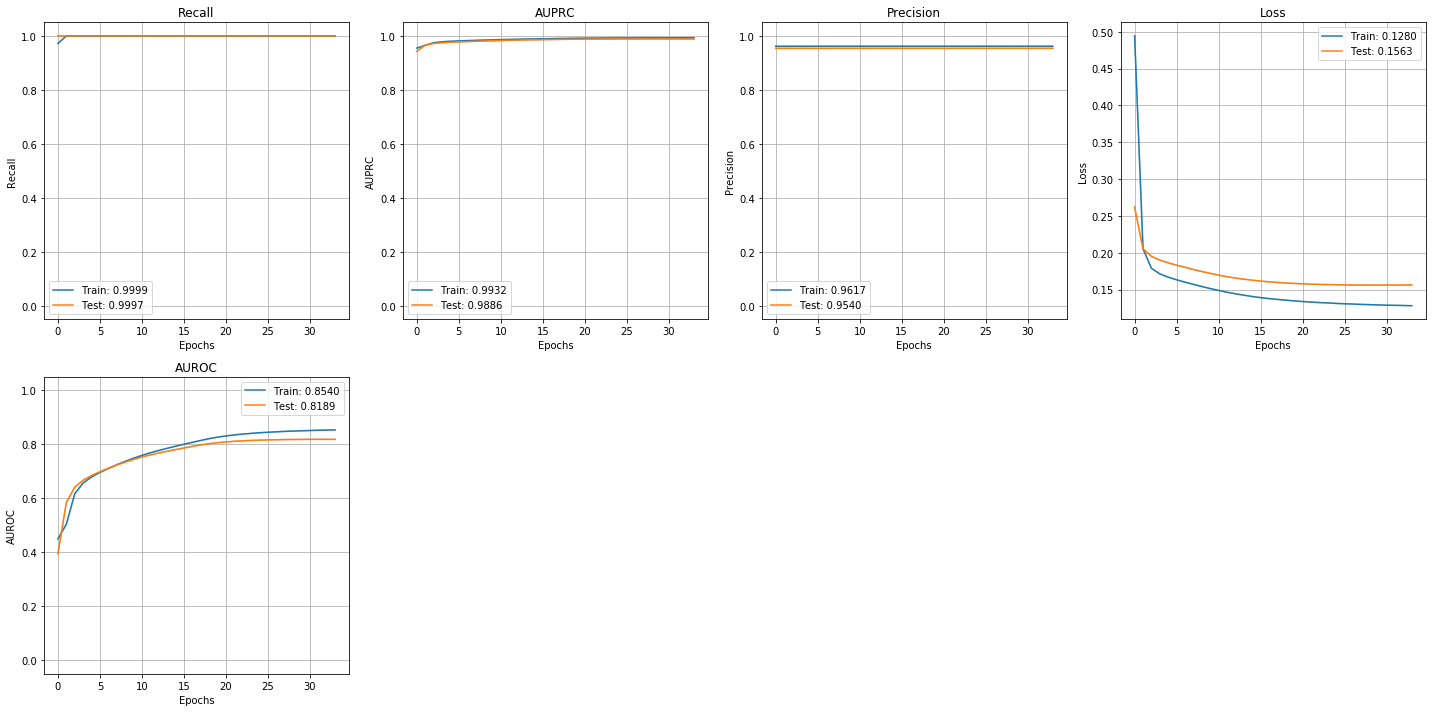

In [11]:
execute_skipgrams_training("leskovec", graph_to_avoid=complete_validation)

### Training using the new experimental setup

Model: "SkipGram"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
context (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1718500     words_embedding[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1718500     context[0][0]                    
___________________________________________________________________________________________

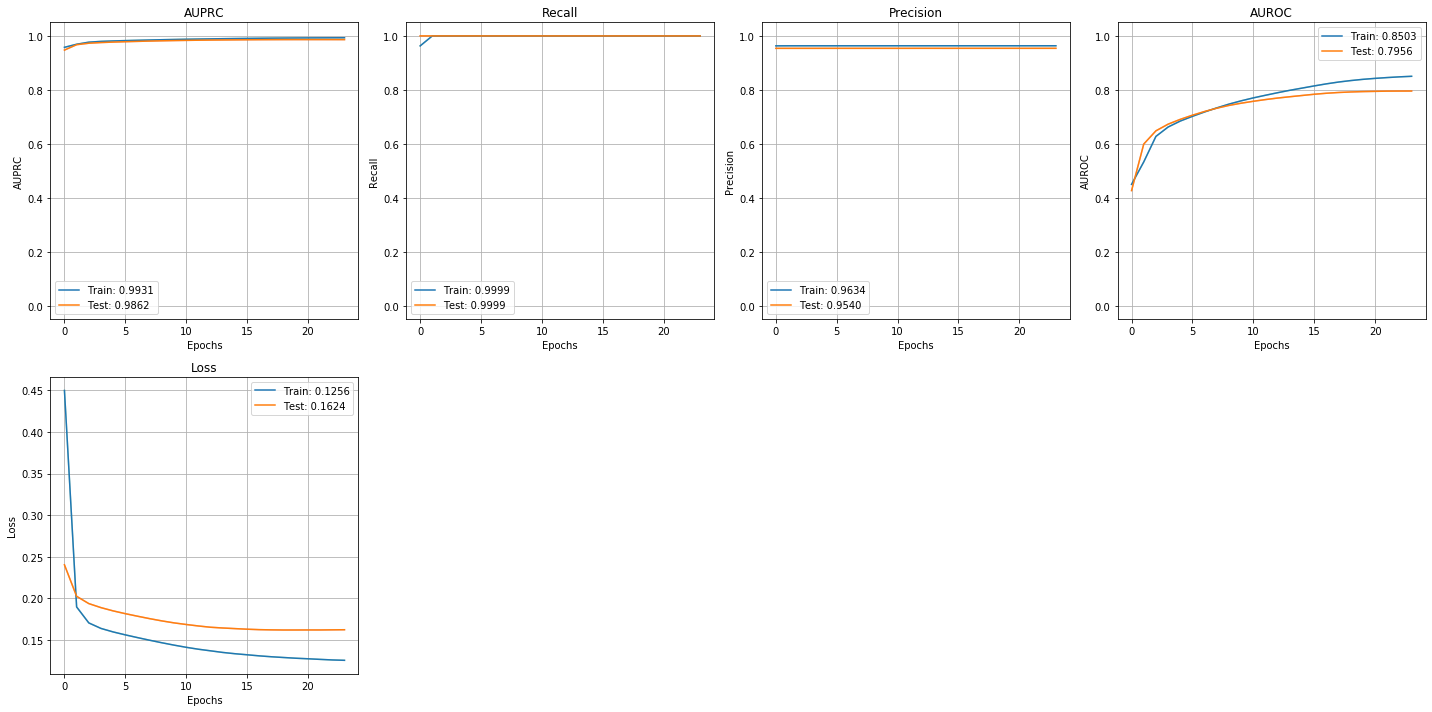

In [9]:
execute_skipgrams_training("new")